In [1]:
import sqlite3
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

Тестовое задание
================

## SQL

В *SQLite* файле `issues.db` находится таблица `history`.

Таблица содержит следующие колонки:
* `issue_key` – уникальный ключ задачи
* `status` – статус задачи
* `minutes_in_status` – количество минут, которое задача находилась в статусе
* `previous_status` – предыдущий статус задачи
* `status_begin` – время перехода задачи в текущий статус
* `status_end` – время окончания нахождения задачи в текущем статусе

Время `status_begin` и `ended_at` указаны в формате unix epoch в *миллисекундах*.

### Задача 1

Напишите SQL запрос, который для всех задач, открытых на момент времени `T`, выведет:
* ключ задачи
* время создания задачи
* статус на момент `T`

Задача считается открытой на момент времени `T`, если к этому времени последний статус задачи был любой кроме `Closed` и `Resolved`.

Оформите запрос таким образом, чтобы, изменив дату, его можно было использовать для поиска открытых задач в любой момент времени как в прошлом, так и в настоящем.

Здесь и далее все даты и времена должны быть переведены в удобочитаемый вид.

#### Решение задачи № 1

In [2]:
con = sqlite3.connect("issues.db")
cur = con.cursor()

In [3]:
print("Введите дату для поиска задачи в формате 'dd.mm.YYYY'")
#t_test= input()

Введите дату для поиска задачи в формате 'dd.mm.YYYY'


In [4]:
t_test='25.11.2020'
print('Введенная дата', t_test)

Введенная дата 25.11.2020


In [5]:
t_test= pd.to_datetime(t_test, format='%d.%m.%Y')
t_test_unix=time.mktime(t_test.timetuple())*1000

In [6]:
cur.execute(f"SELECT issue_key, status_begin, status  FROM history where status!='Closed' and status!='Resolved' and {t_test_unix}>=status_begin and  {t_test_unix}<status_end")
all_res = cur.fetchall() 

In [7]:
all_res_df=pd.DataFrame(all_res, columns = ['issue_key', 'status_begin', 'status'])

In [8]:
# Создание списка переведенных из unix в datetime дат 

creat_time=[]
for i in all_res_df['status_begin'].values:
    creat_time.append(datetime.datetime.fromtimestamp(int(i/1000)))

In [9]:
all_res_df['status_begin']=creat_time

In [10]:
# Окончательный датафрейм 

all_res_df.head()

,issue_key,status_begin,status
0,C-8231,2020-11-19 18:41:55,In Progress
1,C-7791,2020-11-17 13:37:01,In Progress
2,A-28122,2020-11-24 13:50:50,In Progress
3,A-28114,2020-11-24 23:26:31,Waiting for integration
4,A-28109,2020-11-23 16:58:27,In Progress


## Pandas

Файл `task_history.csv` содержит исторические данные системы сборки (e.g. *jenkins*, *teamcity*, etc.)

Каждая запись в истории описывает отдельный запуск задачи `build_name` на рабочей машине `worker`.<br/>
Для любого запуска известны автор `author` и проект `project`, в рамках которого был запущен расчет данной задачи.

### Задача 2

Для каждой недели распечатайте топ-3 пользователей, потребивших наибольшее количество машиночасов.

Выведите для данных пользователей процент потребленных ресурсов от общего объема расчетов за эту неделю.

#### Ответ на задачу № 2

Где author - это пользователи, потребившие наибольшее количество машиночасов, machine_hours - кол-во машиночасов, week - номер недели в году, percentage - процент потребленных машиночасов за эту неделю.

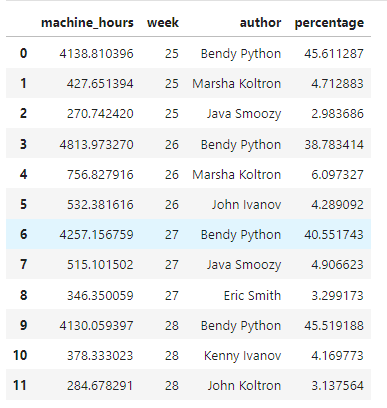

#### Решение задачи № 2

In [11]:
task_history = pd.read_csv('task_history.csv')

In [12]:
task_history['start_time']= pd.to_datetime(task_history['start_time'], format='%Y-%m-%d %H:%M:%S.%f')
task_history['finish_time']= pd.to_datetime(task_history['finish_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [13]:
task_history['machine_hours']=task_history['finish_time']-task_history['start_time']
task_history['week']=task_history['start_time'].dt.strftime("%W")

In [14]:
# Окончательный датасет, включающий столбцы machine_hours - разница между запуском
#  и отключением, и week - номер недели в году 

task_history.head()

,task_id,start_time,finish_time,status,worker,build_name,author,project,machine_hours,week
0,44973,2005-06-26 09:05:45.716,2005-06-26 09:05:45.997,success,worker_00,test_cyan_texture,Kenny Smith,Halo Anniversary,0 days 00:00:00.281000,25
1,44974,2005-06-26 09:05:46.200,2005-06-26 09:05:46.497,success,worker_01,test_cyan_texture,Kenny Smith,Halo Anniversary,0 days 00:00:00.297000,25
2,44975,2005-06-26 09:05:47.357,2005-06-26 09:06:01.213,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary,0 days 00:00:13.856000,25
3,44977,2005-06-26 09:06:19.273,2005-06-26 09:10:44.734,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary,0 days 00:04:25.461000,25
4,44979,2005-06-26 09:12:00.883,2005-06-26 09:14:29.941,success,worker_04,test_cyan_texture,Kenny Smith,Halo Anniversary,0 days 00:02:29.058000,25


In [15]:
# группировка по неделе, чтобы найти общее кол-во машиночасов за каждую неделю.

all_week=task_history.groupby(by=['week'], dropna=True)['machine_hours'].sum()
all_week

week
25   378 days 02:05:33.016000
26   517 days 04:27:13.243000
27   437 days 10:05:08.459000
28   378 days 01:13:38.523000
Name: machine_hours, dtype: timedelta64[ns]

In [16]:
# группировка по неделе, автору

group=task_history.groupby(by=['week', 'author'], dropna=True)['machine_hours'].sum()
group

week  author       
25    Bendy Python    172 days 10:48:37.424000
      Eric Ivanov       1 days 16:07:52.822000
      Eric Koltron      2 days 08:51:30.102000
      Eric Kotlin       1 days 23:39:44.061000
      Eric Smith        7 days 10:45:43.437000
                                ...           
28    Polly Koltron     5 days 13:39:44.393000
      Polly Kotlin      8 days 19:45:09.259000
      Polly Smith       3 days 10:00:07.169000
      Polly Smoozy      3 days 05:47:07.365000
      Polly Xi          1 days 14:42:59.769000
Name: machine_hours, Length: 168, dtype: timedelta64[ns]

In [17]:
week=[]
author=[]
for i in group.index:
    week.append(i[0])
    author.append(i[1])

In [18]:
# Создаю ДатаФрейм по полученным данным 

df = pd.DataFrame(data=(group/np.timedelta64(1, 'h')).values, columns= ['machine_hours'])
df['week']=week
df['author']=author
df.head()

,machine_hours,week,author
0,4138.810396,25,Bendy Python
1,40.131339,25,Eric Ivanov
2,56.858362,25,Eric Koltron
3,47.662239,25,Eric Kotlin
4,178.762066,25,Eric Smith


In [19]:
# Сортирую Датафрейм

sort_group=df.sort_values(by = ['machine_hours'], ascending=False)

In [20]:
#  Отбираю первые три автора в отсортированном датафрейме

answ_Q2=pd.DataFrame()
for i in sorted(set(sort_group['week'])):
    answ_Q2=answ_Q2.append([sort_group[sort_group['week']==str(i)][:3]], ignore_index = True)
answ_Q2

,machine_hours,week,author
0,4138.810396,25,Bendy Python
1,427.651394,25,Marsha Koltron
2,270.742420,25,Java Smoozy
3,4813.973270,26,Bendy Python
4,756.827916,26,Marsha Koltron
5,532.381616,26,John Ivanov
6,4257.156759,27,Bendy Python
7,515.101502,27,Java Smoozy
8,346.350059,27,Eric Smith
9,4130.059397,28,Bendy Python


In [21]:
all_week_df=pd.Series(all_week/ np.timedelta64(1, 'h'))
all_week_df=all_week_df.repeat(3)
all_week_df

week
25     9074.092504
25     9074.092504
25     9074.092504
26    12412.453679
26    12412.453679
26    12412.453679
27    10498.085683
27    10498.085683
27    10498.085683
28     9073.227367
28     9073.227367
28     9073.227367
Name: machine_hours, dtype: float64

In [22]:
# Ищу процент используемых машиночасов для каждого автора на каждой неделе 

answ_Q2['percentage']=answ_Q2['machine_hours']*100/all_week_df.values

In [23]:
answ_Q2

,machine_hours,week,author,percentage
0,4138.810396,25,Bendy Python,45.611287
1,427.651394,25,Marsha Koltron,4.712883
2,270.742420,25,Java Smoozy,2.983686
3,4813.973270,26,Bendy Python,38.783414
4,756.827916,26,Marsha Koltron,6.097327
5,532.381616,26,John Ivanov,4.289092
6,4257.156759,27,Bendy Python,40.551743
7,515.101502,27,Java Smoozy,4.906623
8,346.350059,27,Eric Smith,3.299173
9,4130.059397,28,Bendy Python,45.519188


### Задача 3

Отобразите график с ежедневным потреблением машинного времени каждым проектом.

Для визуализации можно использовать следующие библиотеки: `matplotlib`, `seaborn` или `altair`.

#### Ответ на задачу № 3

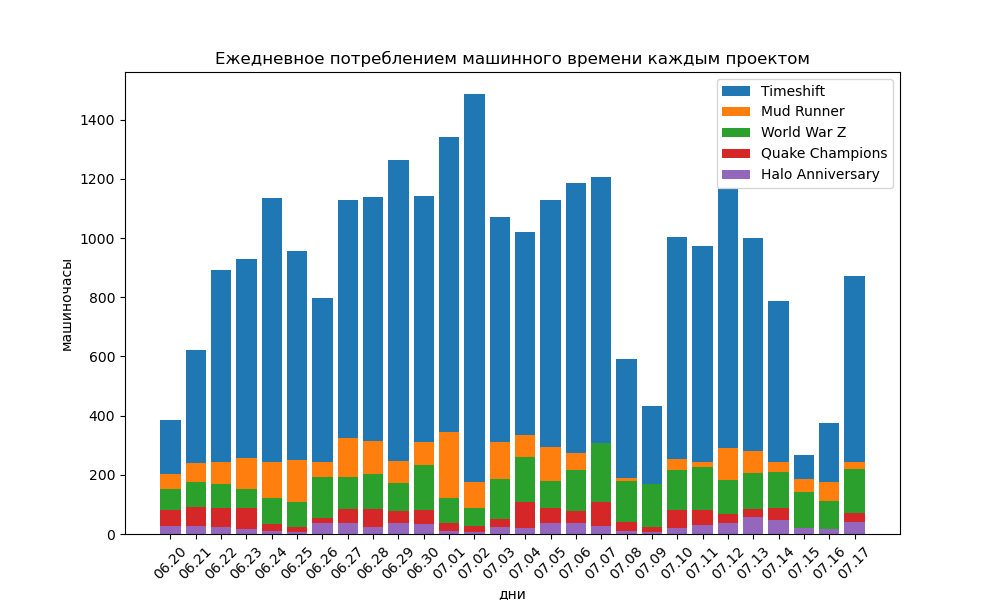



#### Решение задачи № 3

In [24]:
# Определяю день 

task_history['date']=task_history['start_time'].dt.strftime("%m.%d")

In [25]:
# Группировка по дню и проекту 

Q3=task_history.groupby(by=['date', 'project'],dropna=True)['machine_hours'].sum()

In [26]:
# Получаю уникальные даты в формате mm.dd 

date=np.unique(task_history['date'])

In [27]:
name_proj=('Halo Anniversary', 'Mud Runner', 'Quake Champions','Timeshift','World War Z')

In [28]:
# создаю Датафрейм, где каждый столбец соответсвует кол-ву машиночасов для одного проекта за один день

Q3_val=(Q3/ np.timedelta64(1, 'h')).values
Q3_val=Q3_val.reshape(28,5)
answ_Q3=pd.DataFrame(data = Q3_val,columns=name_proj)
answ_Q3['date']=date
answ_Q3.head()

,Halo Anniversary,Mud Runner,Quake Champions,Timeshift,World War Z,date
0,27.675854,203.615363,79.533664,386.530662,150.423432,06.20
1,28.652666,239.868934,90.207290,623.455232,176.060559,06.21
2,22.045459,244.008156,88.698049,892.682759,167.553135,06.22
3,17.847714,256.012110,88.795970,928.137966,152.665095,06.23
4,8.555694,243.461272,33.746687,1134.497059,121.692925,06.24


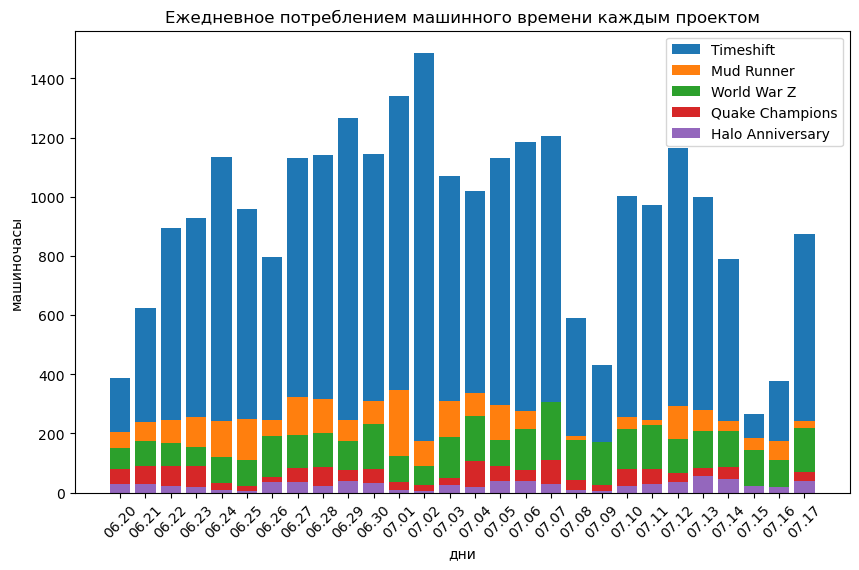

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(date,answ_Q3['Timeshift'], label='Timeshift')
plt.bar(date,answ_Q3['Mud Runner'], label='Mud Runner')
plt.bar(date,answ_Q3['World War Z'],  label='World War Z')
plt.bar(date,answ_Q3['Quake Champions'],  label= 'Quake Champions')
plt.bar(date,answ_Q3['Halo Anniversary'], label= 'Halo Anniversary')
plt.xticks( rotation =45)
plt.title("Ежедневное потреблением машинного времени каждым проектом")
plt.xlabel("дни")
plt.ylabel("машиночасы")
plt.legend(loc='upper right')
#plt.savefig('m_hours_proj')

### Задача 4

Рассмотрим *еженедельное* общее потребление ресурсов. На второй неделе можно заметить всплеск нагрузки с ее последующим планомерным снижением.

Проанализируйте предоставленные данные и найдите, с чем связано подобное поведение.

#### Ответ на задачу № 4 

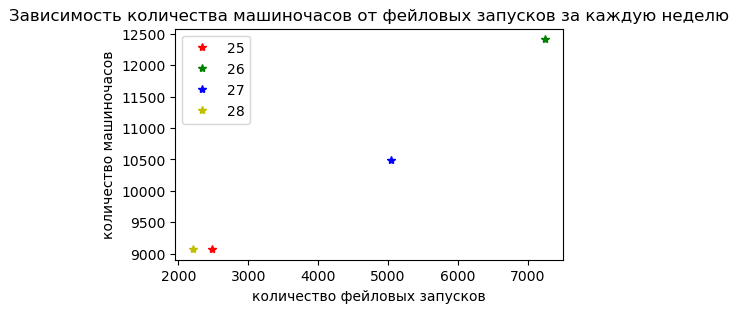

* Во вторую неделю (26) наблюдается самое большое кол-во статусов fail, по графику видно, что имеется определнная зависимость кол-ва машиночасов от кол-ва фейловых запусков. То есть всплеск во вторую неделю (26) обусловлен скачком количества фейловых запусков. Уменьшение количества фейловых запусков в дальнейшем приводит к уменьшению количества машиночасов, приблизительно до уровня первой недели (25).

#### Анализ данных

In [30]:
# кол-во машиночасов для каждой недели, рассчитанное ранее

all_week

week
25   378 days 02:05:33.016000
26   517 days 04:27:13.243000
27   437 days 10:05:08.459000
28   378 days 01:13:38.523000
Name: machine_hours, dtype: timedelta64[ns]

Text(0, 0.5, 'машиночасы')

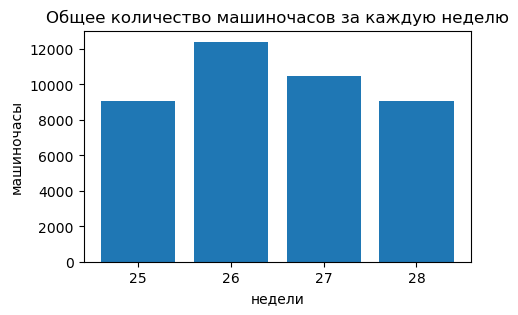

In [31]:
plt.figure(figsize=(5, 3))
plt.bar(all_week.index,all_week/np.timedelta64(1, 'h'))
plt.title("Общее количество машиночасов за каждую неделю")
plt.xlabel("недели")
plt.ylabel("машиночасы")

* Предположение: общее кол-во машиночасов за неделю зависит от кол-ва неудачных запусков 

In [32]:
# кол-во статусов success, fail и cancel для каждой недели 

answ_Q3=pd.DataFrame()
for i in sorted(set(task_history['week'])):
    answ_Q3=answ_Q3.append([task_history['status'][task_history['week']==str(i)].value_counts()], ignore_index = True)
answ_Q3['week']=sorted(set(task_history['week']))

In [33]:
# Общее кол-во запусков - q_launches

answ_Q3['q_launches']=answ_Q3[['success','fail','cancel']].sum(axis=1)
answ_Q3

,success,fail,cancel,week,q_launches
0,33823,2480,790,25,37093
1,29550,7250,2493,26,39293
2,35703,5049,1684,27,42436
3,37949,2207,1514,28,41670


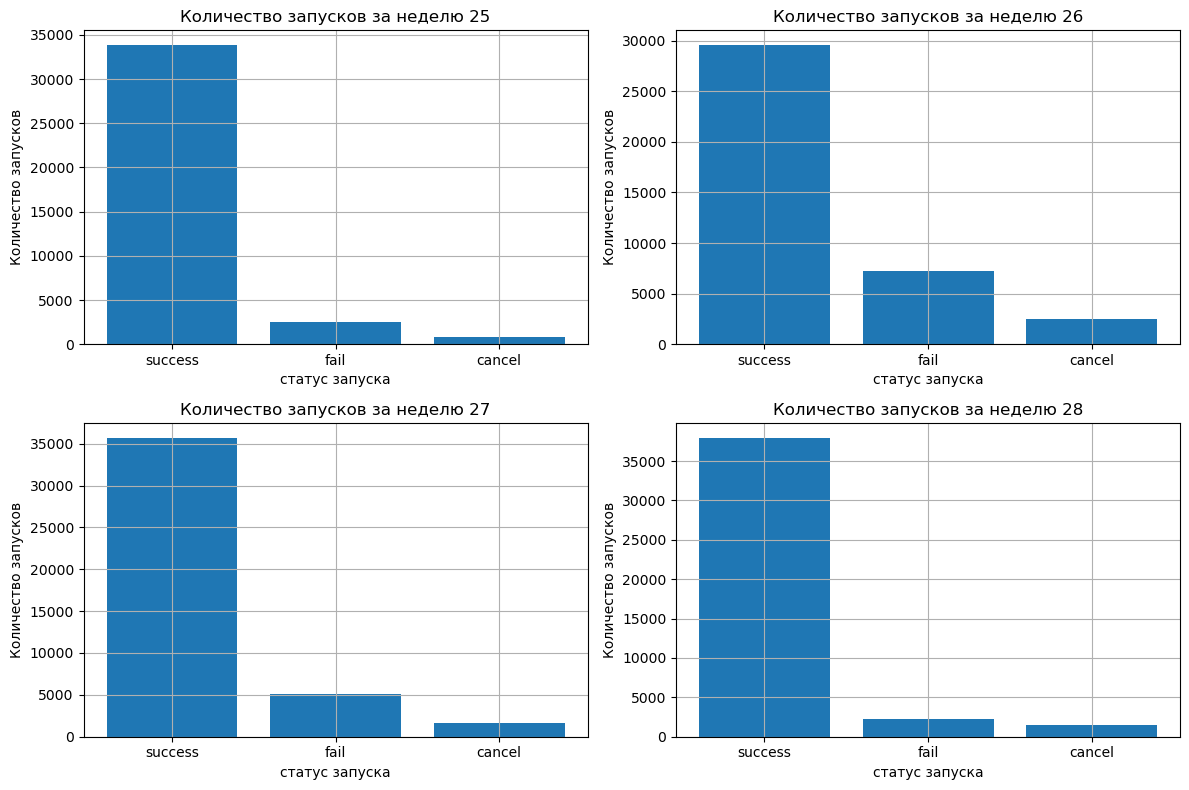

In [34]:
plt.figure(figsize=(12, 8))
for i in range(answ_Q3.shape[0]):
    plt.subplot(2,2,i+1)
    plt.bar(answ_Q3.columns[:-2], answ_Q3.iloc[i][:-2])
    plt.grid(True)
    plt.tight_layout()
    plt.title("Количество запусков за неделю " + answ_Q3['week'][i])
    plt.xlabel("статус запуска")
    plt.ylabel("Количество запусков")
#plt.savefig('колво запус')

* Во вторую неделю (26) наблюдается самое большое кол-во статусов fail и cancel, что скорее всего требует большее кол-во машиночасов. 
* На третьей неделе (27) кол-во failов по-прежнему высокое (по сравнением с первой (25) неделей), но уже меньшее, чем во вторую 
* На четвертой (28) неделе кол-во неудачных запусков примерно равно кол-ву на первой неделе, и кол-во машиночасов почти одинаково 

Зависимость общего количества запусков от недели:

Text(0, 0.5, 'количество запусков')

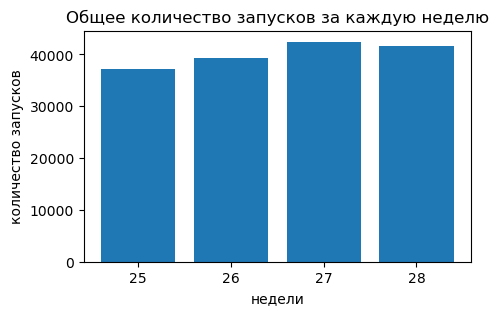

In [35]:
plt.figure(figsize=(5, 3))
plt.bar(answ_Q3['week'],  answ_Q3['q_launches'])
plt.title("Общее количество запусков за каждую неделю")
plt.xlabel("недели")
plt.ylabel("количество запусков")

Кол-во запусков растет с 1ой по 3ю неделю, на 4ой незначительно падает

* Кол-во задач с каждой неделей растет:


In [36]:
task=[]
for i in sorted(set(task_history['week'])):
    task.append(len(task_history['build_name'][task_history['week']==str(i)].value_counts()))

Text(0, 0.5, 'количество задач')

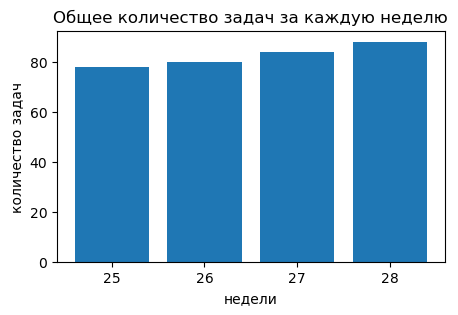

In [37]:
plt.figure(figsize=(5, 3))
plt.bar(sorted(set(task_history['week'])),  task)
plt.title("Общее количество задач за каждую неделю")
plt.xlabel("недели")
plt.ylabel("количество задач")

* Кол-во используемых машин также с каждой неделей растет:

In [38]:
worker=[]
for i in sorted(set(task_history['week'])):
    worker.append(len(task_history['worker'][task_history['week']==str(i)].value_counts()))

Text(0, 0.5, 'количество машин')

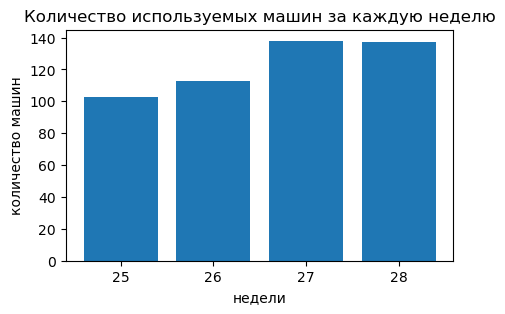

In [39]:
plt.figure(figsize=(5, 3))
plt.bar(sorted(set(task_history['week'])),  worker)
plt.title("Количество используемых машин за каждую неделю")
plt.xlabel("недели")
plt.ylabel("количество машин")

* Кол-во авторов неизменно независимо от недели:

In [40]:
author=[]
for i in sorted(set(task_history['week'])):
    author.append(len(task_history['author'][task_history['week']==str(i)].value_counts()))

Text(0, 0.5, 'Количество пользователей')

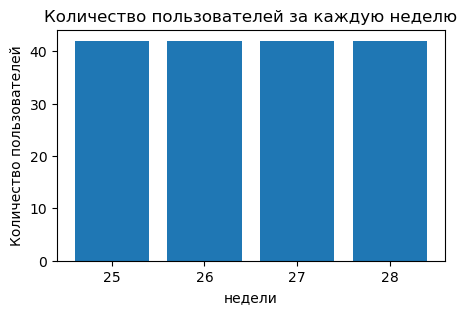

In [41]:
plt.figure(figsize=(5, 3))
plt.bar(sorted(set(task_history['week'])), author)
plt.title("Количество пользователей за каждую неделю")
plt.xlabel("недели")
plt.ylabel("Количество пользователей")

* графики зависимости фейловых и неудачных запусков от кол-ва машиночасов:

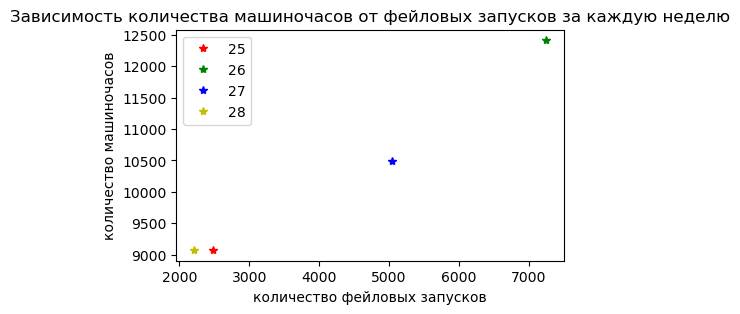

In [42]:
colors=['r*', 'g*', 'b*', 'y*']

plt.figure(figsize=(5, 3))
for i in range(answ_Q3.shape[0]):
    plt.plot((answ_Q3['fail'][i]), (all_week/np.timedelta64(1, 'h'))[i], 
             colors[i], label=answ_Q3['week'][i])
plt.title("Зависимость количества машиночасов от фейловых запусков за каждую неделю")
plt.xlabel("количество фейловых запусков")
plt.ylabel("количество машиночасов")
plt.legend()

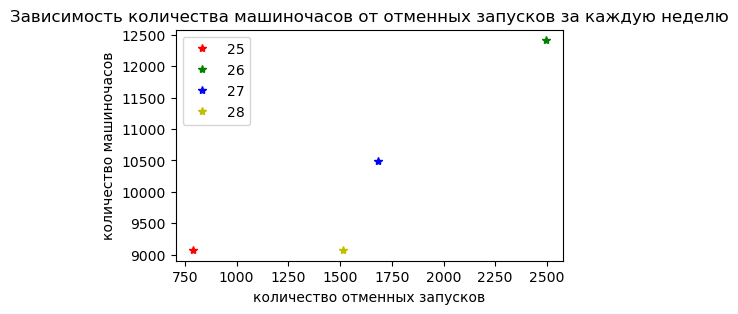

In [43]:
plt.figure(figsize=(5, 3))
for i in range(answ_Q3.shape[0]):
    plt.plot((answ_Q3['cancel'][i]), (all_week/np.timedelta64(1, 'h'))[i], 
             colors[i], label=answ_Q3['week'][i])
plt.title("Зависимость количества машиночасов от отменных запусков за каждую неделю")
plt.xlabel("количество отменных запусков")
plt.ylabel("количество машиночасов")
plt.legend()

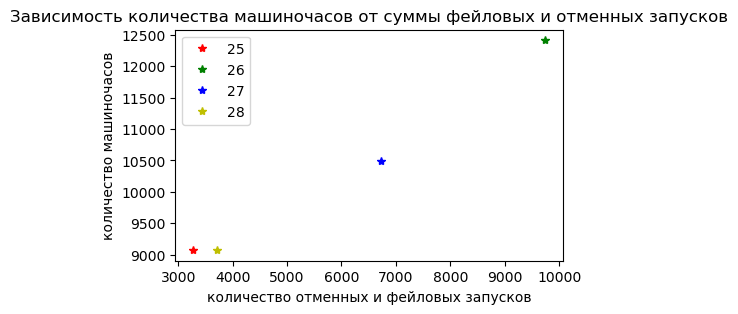

In [44]:
plt.figure(figsize=(5, 3))
for i in range(answ_Q3.shape[0]):
    plt.plot((answ_Q3['fail'][i]+answ_Q3['cancel'][i]), (all_week/np.timedelta64(1, 'h'))[i], 
             colors[i], label=answ_Q3['week'][i])
plt.title("Зависимость количества машиночасов от суммы фейловых и отменных запусков")
plt.xlabel("количество отменных и фейловых запусков")
plt.ylabel("количество машиночасов")
plt.legend()

* Следовательно предположение о том, что кол-во машиночасов зависит от кол-ва неудачных запусков задачи верно, с ростом фейловых запусков растёт количество машиночасов. Также возможна зависимость от суммы фейлов и отменнных задач.